In [1]:
# =============================
# 📦 Imports
# =============================
import os, shutil, random, pandas as pd, numpy as np, datetime
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19, ResNet50
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# AdamW import (supports TF 2.11+); fallback to experimental
try:
    from tensorflow.keras.optimizers import AdamW, SGD
except Exception:
    from tensorflow.keras.optimizers.experimental import AdamW
    from tensorflow.keras.optimizers import SGD

print(tf.__version__)


2.19.0


## 🧱 1) Optional: Create Train/Validation/Test Split from a single `dataset/original/`

In [5]:
def split_data(source_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1.0"
    for cls in os.listdir(source_dir):
        src = os.path.join(source_dir, cls)
        if not os.path.isdir(src):
            continue
        imgs = [os.path.join(src, f) for f in os.listdir(src) if not f.startswith('.')]
        random.shuffle(imgs)
        n = len(imgs)
        n_tr = int(train_ratio * n)
        n_val = int(val_ratio * n)
        splits = {
            'train': imgs[:n_tr],
            'val':   imgs[n_tr:n_tr+n_val],
            'test':  imgs[n_tr+n_val:]
        }
        for split, paths in splits.items():
            dst = os.path.join('/content/drive/MyDrive/dataset', split, cls)
            os.makedirs(dst, exist_ok=True)
            for p in paths:
                shutil.copy(p, dst)

# Run once if you start from dataset/original
# split_data('dataset/original')


## ⚙️ 2) Data Preprocessing & Augmentation (ImageNet normalization, 224×224)

In [7]:
# Clean stray .ipynb_checkpoints
for p in [
    '/content/drive/MyDrive/dataset/train/.ipynb_checkpoints',
    '/content/drive/MyDrive/dataset/val/.ipynb_checkpoints',
    '/content/drive/MyDrive/dataset/test/.ipynb_checkpoints'
]:
    if os.path.exists(p):
        shutil.rmtree(p)

# Augmentation for training; val/test only normalization
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
)
val_datagen  = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

def make_gens(batch_size=16):
    train_gen = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/dataset/train', target_size=(224,224), class_mode='binary', batch_size=batch_size
    )
    val_gen = val_datagen.flow_from_directory(
        '/content/drive/MyDrive/dataset/val', target_size=(224,224), class_mode='binary', batch_size=batch_size
    )
    test_gen = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/dataset/test', target_size=(224,224), class_mode='binary', batch_size=batch_size, shuffle=False
    )
    return train_gen, val_gen, test_gen

# Default generators (can be recreated per run with different batch sizes)
train_gen, val_gen, test_gen = make_gens(batch_size=16)


Found 51 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 13 images belonging to 2 classes.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 🧠 3) Model Factory (VGG19 / ResNet50) + Top Classifier

In [9]:
def build_base(model_name):
    Base = VGG19 if model_name == 'VGG19' else ResNet50
    return Base(weights='imagenet', include_top=False, input_shape=(224,224,3))

def build_model(base_model, dropout):
    base_model.trainable = False  # fine-tuning only later
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout)(x)
    out = Dense(1, activation='sigmoid')(x)
    return Model(inputs=base_model.input, outputs=out)


## 🔧 4) Training Helper (scheduler + early stopping + validation metrics)

In [10]:
def cosine_lr_schedule(epoch, lr_max, T=30):
    # Cosine over epochs
    return float(lr_max * (1 + np.cos(np.pi * epoch / T)) / 2)

def compile_with_optimizer(model, optimizer_name, lr, weight_decay):
    if optimizer_name == 'AdamW':
        opt = AdamW(learning_rate=lr, weight_decay=weight_decay)
    else:  # SGD
        opt = SGD(learning_rate=lr, momentum=0.9, decay=weight_decay)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_and_validate(model_name, params, train_gen, val_gen):
    base = build_base(model_name)
    model = build_model(base, params['dropout'])
    model = compile_with_optimizer(model, params['optimizer'], params['lr'], params['weight_decay'])

    callbacks = [EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)]
    if params['scheduler'] == 'Cosine':
        callbacks.append(LearningRateScheduler(lambda e: cosine_lr_schedule(e, params['lr'], T=max(params['epochs'], 1))))

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=params['epochs'],
        callbacks=callbacks,
        verbose=1
    )

    # Validation metrics
    y_true = val_gen.classes
    y_pred = (model.predict(val_gen) > 0.5).astype('int32')
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return model, (acc, prec, rec, f1), history


## 🔍 5) Hyperparameter Search Space (as per instructions)

In [11]:
search_grid = [
    {'lr': lr, 'optimizer': opt, 'weight_decay': wd, 'dropout': dp, 'batch': bs, 'scheduler': sch, 'epochs': ep}
    for lr in [1e-5, 3e-5, 1e-4, 3e-4]
    for opt in ['AdamW', 'SGD']
    for wd in [0, 1e-5, 1e-4, 1e-3]
    for dp in [0.0, 0.3, 0.5]
    for bs in [8, 16, 32]
    for sch in ['None', 'Cosine']
    for ep in [10, 20, 30]
]

# To limit runtime in class/Colab, cap number of runs
MAX_RUNS = 8  # increase if you have more time/GPU
len(search_grid)


1728

## 📊 6) Experiment Loop + CSV Logging

In [12]:
LOG_FILE = 'experiment_log.csv'
if not os.path.exists(LOG_FILE):
    pd.DataFrame(columns=[
        'Time','Model','LR','Optimizer','WeightDecay','Dropout','Batch','Scheduler','Epochs',
        'ValAcc','ValPrecision','ValRecall','ValF1'
    ]).to_csv(LOG_FILE, index=False)

all_results = []

models_to_try = ['VGG19', 'ResNet50']
run_idx = 0
for model_name in models_to_try:
    for params in search_grid:
        if run_idx >= MAX_RUNS:
            break
        print(f"\n▶️ Run {run_idx+1}/{MAX_RUNS} | {model_name} | {params}")
        # Recreate generators with this run's batch size
        train_gen, val_gen, test_gen = make_gens(batch_size=int(params['batch']))
        model, (acc, prec, rec, f1), history = train_and_validate(model_name, params, train_gen, val_gen)

        row = {
            'Time': datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'Model': model_name,
            'LR': params['lr'],
            'Optimizer': params['optimizer'],
            'WeightDecay': params['weight_decay'],
            'Dropout': params['dropout'],
            'Batch': params['batch'],
            'Scheduler': params['scheduler'],
            'Epochs': params['epochs'],
            'ValAcc': acc,
            'ValPrecision': prec,
            'ValRecall': rec,
            'ValF1': f1
        }
        all_results.append(row)
        pd.DataFrame([row]).to_csv(LOG_FILE, mode='a', header=False, index=False)
        tf.keras.backend.clear_session()
        run_idx += 1

results_df = pd.DataFrame(all_results)
display(results_df.sort_values('ValF1', ascending=False))



▶️ Run 1/8 | VGG19 | {'lr': 1e-05, 'optimizer': 'AdamW', 'weight_decay': 0, 'dropout': 0.0, 'batch': 8, 'scheduler': 'None', 'epochs': 10}
Found 51 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 13 images belonging to 2 classes.
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 54s 7s/step - accuracy: 0.5115 - loss: 2.5644 - val_accuracy: 0.6250 - val_loss: 1.2973
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step - accuracy: 0.6867 - loss: 1.0561 - val_accuracy: 0.6250 - val_loss: 1.0265
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step - accuracy: 0.8816 - loss: 0.3301 - val_accuracy: 0.6250 - val_loss: 0.7435
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 51s 8s/step - accuracy: 0.8438 - loss: 1.1885 - val_accuracy: 0.7500 - val_loss: 0.7497
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.8454 - loss: 0.2770 - val_accuracy: 0.7500 - val_loss: 0.5780
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.9504 - loss: 0.0509 - val_accuracy: 0.7500 - val_loss: 0.4972
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.8761 - loss: 0.3207 - val_accuracy: 0.7500 - val_loss: 0.5070
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.9619 - loss: 0.0931 - val_accuracy: 0.7500 - val_loss: 0.3650
Epoch 9/

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 53s 8s/step - accuracy: 0.5616 - loss: 6.9434 - val_accuracy: 0.5000 - val_loss: 1.6347
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 47s 7s/step - accuracy: 0.4538 - loss: 3.2258 - val_accuracy: 0.7500 - val_loss: 1.2278
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.7256 - loss: 2.2138 - val_accuracy: 0.7500 - val_loss: 1.1437
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step - accuracy: 0.8937 - loss: 0.8432 - val_accuracy: 0.7500 - val_loss: 0.6675
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step - accuracy: 0.7789 - loss: 1.0487 - val_accuracy: 0.6250 - val_loss: 0.4102
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step - accuracy: 0.7916 - loss: 0.8284 - val_accuracy: 0.8750 - val_loss: 0.2969
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 48s 7s/step - accuracy: 0.8781 - loss: 0.6779 - val_accuracy: 0.8750 - val_loss: 0.2848
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step - accuracy: 0.9346 - loss: 0.2467 - val_accuracy: 0.8750 - val_loss: 0.2788
Epoch 9/

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 49s 7s/step - accuracy: 0.5197 - loss: 4.5811 - val_accuracy: 0.6250 - val_loss: 2.2617
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 52s 8s/step - accuracy: 0.6857 - loss: 1.5353 - val_accuracy: 0.6250 - val_loss: 1.1695
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 49s 7s/step - accuracy: 0.7371 - loss: 1.1848 - val_accuracy: 0.8750 - val_loss: 0.3360
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.8119 - loss: 0.3647 - val_accuracy: 1.0000 - val_loss: 0.1189
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.8397 - loss: 0.6165 - val_accuracy: 1.0000 - val_loss: 0.0829
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 49s 8s/step - accuracy: 0.8748 - loss: 0.3687 - val_accuracy: 1.0000 - val_loss: 0.0410
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.9161 - loss: 0.2524 - val_accuracy: 1.0000 - val_loss: 0.0215
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.8790 - loss: 0.3115 - val_accuracy: 1.0000 - val_loss: 0.0143
Epoch 9/

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 49s 7s/step - accuracy: 0.5698 - loss: 6.0592 - val_accuracy: 0.5000 - val_loss: 2.7533 - learning_rate: 1.0000e-05
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.5928 - loss: 2.7066 - val_accuracy: 0.5000 - val_loss: 3.5211 - learning_rate: 9.7553e-06
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 51s 7s/step - accuracy: 0.7953 - loss: 0.8682 - val_accuracy: 0.6250 - val_loss: 2.2135 - learning_rate: 9.0451e-06
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.8069 - loss: 0.9504 - val_accuracy: 0.6250 - val_loss: 1.2707 - learning_rate: 7.9389e-06
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.7623 - loss: 1.4350 - val_accuracy: 0.6250 - val_loss: 1.1154 - learning_rate: 6.5451e-06
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.9422 - loss: 0.2521 - val_accuracy: 0.7500 - val_loss: 1.0259 - learning_rate: 5.0000e-06
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 86s 7s/step - accuracy: 0.9373 - loss: 0.1771 - val_

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 49s 7s/step - accuracy: 0.5861 - loss: 2.9370 - val_accuracy: 0.2500 - val_loss: 2.5269 - learning_rate: 1.0000e-05
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.5938 - loss: 1.6504 - val_accuracy: 0.2500 - val_loss: 2.2117 - learning_rate: 9.9384e-06
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.6899 - loss: 1.4336 - val_accuracy: 0.5000 - val_loss: 1.2793 - learning_rate: 9.7553e-06
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.7781 - loss: 1.0243 - val_accuracy: 0.6250 - val_loss: 1.5636 - learning_rate: 9.4550e-06
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.8487 - loss: 0.5443 - val_accuracy: 0.6250 - val_loss: 1.4305 - learning_rate: 9.0451e-06
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.8694 - loss: 0.5206 - val_accuracy: 0.6250 - val_loss: 1.0276 - learning_rate: 8.5355e-06
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.8890 - loss: 0.2497 - val_

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

▶️ Run 6/8 | VGG19 | {'lr': 1e-05, 'optimizer': 'AdamW', 'weight_decay': 0, 'dropout': 0.0, 'batch': 8, 'scheduler': 'Cosine', 'epochs': 30}
Found 51 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 13 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 48s 7s/step - accuracy: 0.3807 - loss: 3.6461 - val_accuracy: 0.1250 - val_loss: 4.7359 - learning_rate: 1.0000e-05
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.7135 - loss: 0.9537 - val_accuracy: 0.2500 - val_loss: 3.7932 - learning_rate: 9.9726e-06
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.7507 - loss: 1.2352 - val_accuracy: 0.2500 - val_loss: 3.0552 - learning_rate: 9.8907e-06
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.7996 - loss: 0.5685 - val_accuracy: 0.3750 - val_loss: 2.5266 - learning_rate: 9.7553e-06
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.8604 - loss: 0.7119 - val_accuracy: 0.3750 - val_loss: 2.2207 - learning_rate: 9.5677e-06
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.9270 - loss: 0.3707 - val_accuracy: 0.3750 - val_loss: 1.9920 - learning_rate: 9.3301e-06
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.9512 - loss: 0.1680 - val_

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

▶️ Run 7/8 | VGG19 | {'lr': 1e-05, 'optimizer': 'AdamW', 'weight_decay': 0, 'dropout': 0.0, 'batch': 16, 'scheduler': 'None', 'epochs': 10}
Found 51 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 13 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 49s 11s/step - accuracy: 0.5334 - loss: 3.7363 - val_accuracy: 0.6250 - val_loss: 1.1838
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 11s/step - accuracy: 0.6898 - loss: 1.5096 - val_accuracy: 0.6250 - val_loss: 0.5045
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 15s/step - accuracy: 0.7273 - loss: 0.8191 - val_accuracy: 1.0000 - val_loss: 0.2610
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 11s/step - accuracy: 0.7321 - loss: 0.6187 - val_accuracy: 1.0000 - val_loss: 0.1719
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 11s/step - accuracy: 0.9128 - loss: 0.1842 - val_accuracy: 1.0000 - val_loss: 0.1770
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 15s/step - accuracy: 0.9410 - loss: 0.1128 - val_accuracy: 0.8750 - val_loss: 0.2070
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 11s/step - accuracy: 0.9275 - loss: 0.4163 - val_accuracy: 1.0000 - val_loss: 0.1906
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 15s/step - accuracy: 0.8792 - loss: 0.4612 - val_accuracy: 1.0000 - val_loss: 0.1404


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 48s 11s/step - accuracy: 0.4653 - loss: 4.5827 - val_accuracy: 0.2500 - val_loss: 3.8304
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 15s/step - accuracy: 0.4200 - loss: 4.0307 - val_accuracy: 0.2500 - val_loss: 3.3983
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 11s/step - accuracy: 0.6397 - loss: 1.8978 - val_accuracy: 0.2500 - val_loss: 2.4542
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 15s/step - accuracy: 0.7225 - loss: 1.0803 - val_accuracy: 0.6250 - val_loss: 1.7311
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 15s/step - accuracy: 0.7623 - loss: 0.7885 - val_accuracy: 0.7500 - val_loss: 1.2582
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 11s/step - accuracy: 0.9212 - loss: 0.1633 - val_accuracy: 0.7500 - val_loss: 1.0425
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 82s 15s/step - accuracy: 0.9090 - loss: 0.4436 - val_accuracy: 0.7500 - val_loss: 0.9198
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 11s/step - accuracy: 0.9436 - loss: 0.2348 - val_accuracy: 0.8750 - val_loss: 0.8428


,Time,Model,LR,Optimizer,WeightDecay,Dropout,Batch,Scheduler,Epochs,ValAcc,ValPrecision,ValRecall,ValF1
0,2025-11-04 18:53:22,VGG19,0.00001,AdamW,0,0.0,8,None,10,0.875,1.000000,0.75,0.857143
2,2025-11-04 19:09:33,VGG19,0.00001,AdamW,0,0.0,8,None,30,0.750,0.750000,0.75,0.750000
7,2025-11-04 20:06:47,VGG19,0.00001,AdamW,0,0.0,16,None,20,0.625,0.666667,0.50,0.571429
4,2025-11-04 19:33:42,VGG19,0.00001,AdamW,0,0.0,8,Cosine,20,0.625,0.666667,0.50,0.571429
6,2025-11-04 19:55:18,VGG19,0.00001,AdamW,0,0.0,16,None,10,0.500,0.500000,0.50,0.500000
3,2025-11-04 19:18:15,VGG19,0.00001,AdamW,0,0.0,8,Cosine,10,0.500,0.500000,0.25,0.333333
5,2025-11-04 19:48:58,VGG19,0.00001,AdamW,0,0.0,8,Cosine,30,0.500,0.500000,0.25,0.333333
1,2025-11-04 19:02:11,VGG19,0.00001,AdamW,0,0.0,8,None,20,0.375,0.333333,0.25,0.285714


## 🧩 7) Retrain Best Config (unfreeze last conv block) and Evaluate on **Test**

Best Validation Run ->
Time            2025-11-04 18:53:22
Model                         VGG19
LR                          0.00001
Optimizer                     AdamW
WeightDecay                       0
Dropout                         0.0
Batch                             8
Scheduler                      None
Epochs                           10
ValAcc                        0.875
ValPrecision                    1.0
ValRecall                      0.75
ValF1                      0.857143
Name: 0, dtype: object
Found 51 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 13 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 76s 10s/step - accuracy: 0.4620 - loss: 3.0567 - val_accuracy: 0.2500 - val_loss: 3.8241
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 75s 11s/step - accuracy: 0.5855 - loss: 1.9293 - val_accuracy: 0.2500 - val_loss: 3.4574
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 71s 10s/step - accuracy: 0.6494 - loss: 1.7831 - val_accuracy: 0.2500 - val_loss: 3.1735
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 71s 11s/step - accuracy: 0.6137 - loss: 1.0658 - val_accuracy: 0.2500 - val_loss: 2.9712
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 74s 11s/step - accuracy: 0.6314 - loss: 1.3603 - val_accuracy: 0.2500 - val_loss: 2.7284
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 71s 10s/step - accuracy: 0.6570 - loss: 0.9224 - val_accuracy: 0.2500 - val_loss: 2.4749
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 70s 11s/step - accuracy: 0.7105 - loss: 0.9080 - val_accuracy: 0.2500 - val_loss: 2.2328
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 72s 10s/step - accuracy: 0.7862 - loss: 0.6964 - val_accuracy: 0.3750 - val_loss: 2.0429


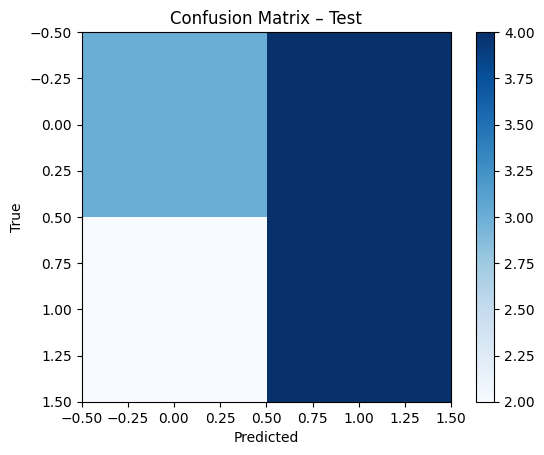

              precision    recall  f1-score   support

     ferrite       0.60      0.43      0.50         7
    pearlite       0.50      0.67      0.57         6

    accuracy                           0.54        13
   macro avg       0.55      0.55      0.54        13
weighted avg       0.55      0.54      0.53        13



In [13]:
if len(results_df) == 0:
    logs = pd.read_csv(LOG_FILE)
else:
    logs = results_df.copy()

best = logs.loc[logs['ValF1'].idxmax()]
print('Best Validation Run ->')
print(best)

# Recreate generators for best batch size
train_gen, val_gen, test_gen = make_gens(batch_size=int(best['Batch']))

# Build best model
base = build_base(best['Model'])
final_model = build_model(base, float(best['Dropout']))
final_model = compile_with_optimizer(final_model, best['Optimizer'], float(best['LR']), float(best['WeightDecay']))

# Fine-tune: unfreeze last ~8 layers
for layer in base.layers[-8:]:
    layer.trainable = True
final_model = compile_with_optimizer(final_model, best['Optimizer'], float(best['LR'])/10.0, float(best['WeightDecay']))

final_model.fit(train_gen, validation_data=val_gen, epochs=10, verbose=1)

# Test metrics
y_true = test_gen.classes
y_pred = (final_model.predict(test_gen) > 0.5).astype('int32')
t_acc = accuracy_score(y_true, y_pred)
t_prec = precision_score(y_true, y_pred)
t_rec = recall_score(y_true, y_pred)
t_f1 = f1_score(y_true, y_pred)
print(f"\n🏁 Test Metrics -> Acc:{t_acc:.3f} | Prec:{t_prec:.3f} | Rec:{t_rec:.3f} | F1:{t_f1:.3f}")

cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix – Test')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.colorbar(); plt.show()
print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))


## 🧾 8) Reflection / Observations

- Which hyperparameters improved validation F1?
- Does Cosine scheduler help over no scheduler?
- Any overfitting signs? Compare train vs val curves.
- Compare VGG19 vs ResNet50 performance and training time.
